In [1]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [2]:
import numpy as np
import pandas as pd

df1 = pd.read_csv('Cleaned-P&P data.csv')

blanks = []  # start with an empty list`

# for i,c,d,inc,sd in df1.itertuples():  # iterate over the DataFrame
#         if c == 'O' or c=='E':         # test 'review' for whitespace
#             blanks.append(i)     # add matching index numbers to the list
df1.drop(blanks, inplace=True)
df1["desc"] = df1["short_des"] + '. ' + df1["desc"]
df1.reset_index(drop=True,inplace=True)


In [3]:

df2 = pd.read_csv('Cleaned-P&P data.csv')
blanks2 = []  # start with an empty list`

# for i,c,d,inc,sd in df2.itertuples():  # iterate over the DataFrame
#         if c == 'O' or c=='E':         # test 'review' for whitespace
#             blanks2.append(i)     # add matching index numbers to the list
df2.drop(blanks2, inplace=True)
df2.reset_index(drop=True,inplace=True)

dataset = pd.concat([df1, df2], ignore_index=True)

In [4]:
# Cleaning the texts
import re
corpus = []
all_words = []
max_len=0
for i in range(0, 504):

    review = re.sub('\w\d{7}', ' ', dataset['desc'][i])
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    review = ' '.join(review)
    
    review = nlp(review)
    review = [word.text for word in review]
   # for word.text in review:
        
    all_words.append(review) 
    if len(review) > max_len:
        max_len = len(review)
    ds = ' '.join(review)
#    for word2vec we want an array of vectors
    corpus.append(ds)
    

dpf = pd.read_csv('Del-Pass.csv')



keys_list = dpf['kpattern'].tolist()
regex = re.compile(r'(' + '|'.join(keys_list) + r')') 

cus_list = ['remove','removed','cancelled', 'cancel' ,'deleted']
regey = re.compile(r'(' + '|'.join(cus_list) + r')') 

import nltk
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
additional =["thank you","please","hello","hi","advise","hin't","st","nd","rd","th","thank"]
stopwords = stopwords + additional
remov=[]
for ele in stopwords:
    matches = re.findall("n't",ele)
    matches2 = re.findall("'nt",ele)
    if len(matches)>0 or len(matches2)>0:
        remov.append(ele)
stopwords = [word for word in stopwords if word not in remov]

In [5]:
print(max_len)

113


In [6]:
all_words = [j for sub in all_words for j in sub] 

In [7]:
unique_words = set(all_words)
print(len(unique_words))
vocab_length = len(unique_words) + 10
vocab_length

760


770

In [11]:
ref_corpus=[]
for text in corpus:           
            trans = regex.sub(lambda m: m.group().replace(m.group(),"del-pass"),text)
            trans_ref = regey.sub(lambda n: n.group().replace(n.group(),"delete"),trans)
             
            ref_corpus.append(trans_ref)


In [55]:
X = ref_corpus
len(X)

504

In [56]:
dataset['Clean desc'] = X

In [66]:
datadf = dataset[dataset['Clean desc'] != '']

In [68]:
len(datadf)

504

### Transform into word vecs

In [58]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(dataset['Clean desc']).split(), [index]) for index, dataset in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(dataset['Clean desc']).split()) for index, dataset in df_x.iterrows()]))
                                 
                    


In [69]:
doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr.fit(datadf)
doc2vec_vectors = doc2vec_tr.transform(datadf)

100%|████████████████████████████████████████████████████████████████████████████| 504/504 [00:00<00:00, 252108.43it/s]


#### Using spacy to create word vecs

In [15]:
doc2vec_vectors  = [nlp(text).vector for text in X]

### Train Auto-Encoder Neural Network

In [80]:
from sklearn.neural_network import MLPRegressor

auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 1200,
                                                 300, 
                                                 1200,
                                               ))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

In [81]:
auto_encoder.score(predicted_vectors, doc2vec_vectors)

0.9912216027413632

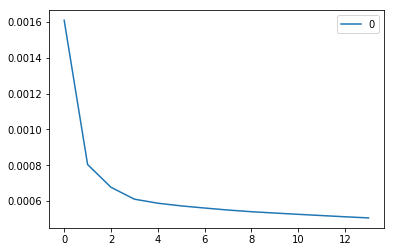

In [82]:
pd.DataFrame(auto_encoder.loss_curve_).plot()